# Using Sensitivity Analysis to Interrogate Models

Will Usher, UCL Energy Institute

10th December 2015

## How to use this notebook

There are several alternative ways in which you can use this notebook.
1. Access online here [![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/willu47/SATut) (changes won't be saved)
2. [Download](http://www.github.com/willu47/SATut) the notebooks, and install jupyter and python
    1. For Mac, open terminal and type
        `pip install jupyter notebook ipython`
    2. For Windows

# Agenda

1. [What is Sensitivity Analysis?](#What-is-Sensitivity-Analysis?)
1. [Sensitivity Analysis Techniques](#Sensitivity-Analysis-Techniques)
1. [An Interactive Example](#Sensitivity-Analysis-in-Practice:-Vehicle-to-Grid-(V2G))
1. [Summary](#Summary)

In [6]:
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
figsize(11, 9)

/Users/will2/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


#  Introduction

## Uncertainty and Modelling

We use models to encode natural phenomena, to project and forecast, to understand, to learn.

Examples of models:
* discounted cash flow analysis
* [Gina coefficient](https://en.wikipedia.org/wiki/Gini_coefficient#Based_on_just_two_levels_of_income) (statistical measure of inequality)
* UKTM - energy system model of the United Kingdom
* [MetUM](http://www.metoffice.gov.uk/research/modelling-systems/unified-model) - UK weather forecasting

## What is Sensitivity Analysis?

“...the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs.” 

Four settings for sensitivity analysis:
* **Factor fixing** - which parameters can we ignore?
* **Factor prioritisation** - which parameters are most influential?
* Factor mapping - which inputs matter for just this space in the model output?
* (Metamodelling) - which parameters can I use to model my model?

There are two families of approaches:
* Local approaches
* Global approaches

Sensitivity Analysis is strongly linked to uncertainty.

When considering the range over which a mode input should be explored, 
you are actually considering the plausibility of this range.
Sensitivity Analysis makes you critically analyse your assumptions.

### Local versus Global Approaches

* Local approaches
    * e.g. one-at-a-time (OAT) approach
    * low data requirements
    * quick and easy to conduct
    * do not capture interactions between inputs
    * misleading for non-linear models


* Global approaches
    * e.g. Sobol analysis
    * often need probabilistic data
    * computationally demanding
    * capture interactions between inputs
    * handle non-linear and non-additive models

### Sensitivity Analysis Techniques 

(adapted from Flechsig (2012), Saltelli(2008))

| Type | Morris | Variance | Factorial | Monte Carlo | Local SA |
|:------|------|------|------|------|------|
|Model independent? | yes | yes | yes | yes | yes|
|Sample source | levels | distributions | levels | distributions | levels |
|No. factors | $20-100^1$ | $<20^1$ | $>100^1$ | $<20$ | $<100$ |
|Factor range | global | global | global | global | local |
|Multi-factor variation | yes | yes | yes | yes | no |
|Correlated factors? | no | no | yes | yes | no |
|Cost (for k factors)? | $10(k+1)$ | $500(k+2)$ | $k \to 2k$ | $500+1$ | $2(k+1)$ |
|Estimated CPU time$^2$ | 1 day | 11 days | 3 hours | ~2 days | 1 hour |
  
[1] using groups of factors would enable larger numbers of factors to be explored
[2] assuming 5 minutes per simulation and 30 groups of factors

### Global Sensitivity Analysis

Screening approaches, such as Fractional Factorial and Morris, **rank** inputs according to their influence upon the output.

Variance-based approaches, such as Saltelli and DMIM, **score** the sensitivity of each input with a numerical value, called the sensitivity index. Sensitivity indices come in several forms:
* First-order indices: measures the contribution to the output variance by a single model input alone.
* Second-order indices: measures the contribution to the output variance caused by the interaction of two model inputs.
* Total-order index: measures the contribution to the output variance caused by a model input, including both its first-order effects (the input varying alone) and all higher-order interactions.

# Sensitivity Analysis in Practice: Vehicle to Grid (V2G)

[Kempton (2005)](http://www.sciencedirect.com/science/article/pii/S0378775305000352) raise the prospect of using battery electric vehicles (BEVs) as mobile storage devices for electricity.  Other than pumped hydro, the electricity grid has virtually no storage devices.  Electricity storage could facilitate the integration of variable output renewable technologies such as wind turbines and solar photovoltaics.

The concept of V2G is that the owners of electric (or even hydrogen fuel cell) vehicles could be paid by the System Operator (National Grid in the UK) for the use of their cars as giant batteries.

There are three services that V2G could provide:
* Regulation - helps keep the grid operating at 60 Hz by exporting energy during times of extra demand or importing during times of extra supply
* Spinning Reserve - an always-available (but not necessarily generating) backup in case a power plant drops offline
* Peak Power - exports electricity to the grid during times of peak demand (e.g. 5-7pm)

 |Service | Revenue | Cost|
 |---- | ---- | ----|
 |Regulation | Energy Exported, Saving on Energy Imported | Cost of Energy, Degradation of Battery|
 |Spinning Reserve | Capacity Available, Energy Exported | Cost of Energy, Degradation of Battery|
 |Peak Power | Capacity Available, Energy Exported | Cost of Energy, Degradation of Battery|

## Tesla Model S

![Tesla](https://www.teslamotors.com/sites/default/files/images/model-s/gallery/exterior/hero-01.jpg?20151030)

Parameter | Min | Max
---| ---| ---
Battery Size | 70 kWh | 85 kWh
Charge Connectors | 230V 10 Amp (2.3 kW) | 400V 32 Amp (22 kW)
Stated efficiency | ~ 5.5 km/kWh |

## Nissan Leaf

![Nissan Leaf](http://www.nissan.co.uk/content/dam/pes/default/leaf/galleries/photos/exterior_view/720x450/gallery_0000_01.jpg)

Parameter | Min | Max
---| ---| ---
Battery Size | 24 kWh | 30 kWh
Charge Connectors | 2.3 kW | 6.6 kW
Stated efficiency | ~5.5 km/kWh |

In [39]:
def max_vehicle_power(connector_power,
                      stored_energy,
                      distance_driven,
                      range_buffer,
                      dispatch_time,
                      driving_efficiency=4.025,
                      inverter_efficiency=0.93
                      ):
    '''
    Compute the maximum electrical power output of a vehicle battery when
    connected to the electricity grid
    
    Arguments:
        connector_power - the power capacity of the connection to the grid
        stored_energy - energy available as DC kWh to the inverter
        distance_driven - distance driven (km) since energy storage full
        range_buffer - minimum range required by the driver (km)
        driving_efficiency - 4.025 (km/kWh)
        inverter_efficiency - electrical conversion efficiency of DC to AC
                              inverter (93%)
        dispatch_time - time over which the vehicle's stored energy 
                        is dispatched (hours)
    
    Returns:
        the maximum power in kW of a vehicle connected to the grid
    '''


    max_vehicle_power = ((stored_energy - \
                         ((distance_driven + range_buffer) \
                         / driving_efficiency)) * inverter_efficiency) \
                         / dispatch_time
    
    return np.maximum(0, np.minimum(connector_power, max_vehicle_power))

### One-at-time approach

First, we're going to try the **one-at-a-time** (OAT) approach.

The sliders in the example are set up for the Nissan Leaf.

In [123]:
@interact(connector=widgets.FloatSlider(value=2.3, min=2.3, max=22, step=0.5), 
          battery_size=widgets.FloatSlider(value=24, min=10, max=100, step=5), 
          distance_driven=widgets.FloatSlider(value=0, min=0, max=100, step=5), 
          range_buffer=widgets.FloatSlider(value=0, min=0, max=100, step=10),
          dispatch_time=widgets.FloatSlider(value=8, min=1, max=24, step=1))
def plot_power(connector, battery_size, distance_driven, range_buffer, dispatch_time):
    power = max_vehicle_power(connector,
                      battery_size,
                      distance_driven,
                      range_buffer,
                      dispatch_time
                      )
    return print("The maximum power is {} kW".format(round(power, 2)))

The maximum power is 2.3 kW


In [124]:
def monte_carlo_large(data):
    dispatch_time = 4
    y = max_vehicle_power(data[0], data[1], data[2], data[3], data[6], data[4], data[5])
    return y

### Scatter plots

Scatter plots can tell you quite a lot about the relationship between the model inputs and outputs.

Each of the scatter plots shows _all_ the model outputs on the y-axis, but re-ordered by the relatinship to the input variable (on the x-axis).

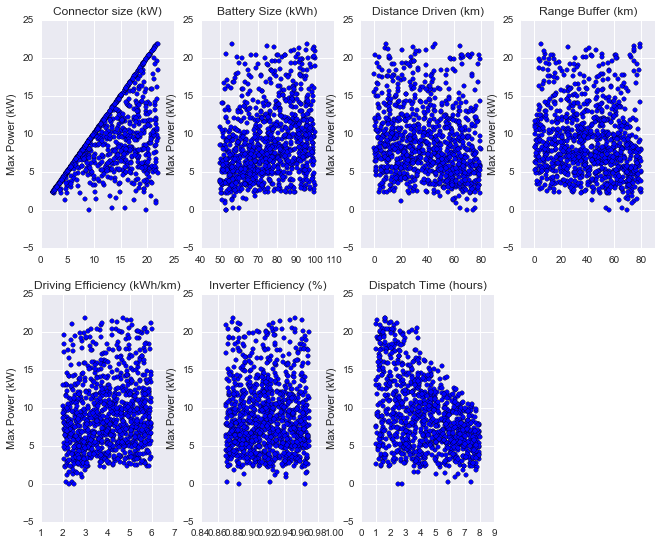

In [126]:
number_sims = 1000

# Make some random data in the correct ranges
mc_connector = np.random.uniform(2.3, 22, number_sims)
mc_battery_size = np.random.uniform(50, 100, number_sims)
mc_distance_driven = np.random.uniform(0, 80, number_sims)
mc_range_buffer = np.random.uniform(0, 80, number_sims)
mc_driving_eff = np.random.uniform(2, 6, number_sims)
mc_inv_eff = np.random.uniform(0.87, 0.97, number_sims)
mc_dispatch_time = np.random.uniform(1, 8, number_sims)

data = np.array((mc_connector, 
                 mc_battery_size, 
                 mc_distance_driven, 
                 mc_range_buffer, 
                 mc_driving_eff, 
                 mc_inv_eff, 
                 mc_dispatch_time))

# Run the code
y = monte_carlo_large(data)

# Make some scatter plots to compare the results
plt.subplot(241)
plt.scatter(mc_connector, y)
plt.title("Connector size (kW)")
plt.ylabel("Max Power (kW)")
plt.subplot(242)
plt.scatter(mc_battery_size, y)
plt.title("Battery Size (kWh)")
plt.ylabel("Max Power (kW)")
plt.subplot(243)
plt.scatter(mc_distance_driven, y)
plt.title("Distance Driven (km)")
plt.ylabel("Max Power (kW)")
plt.subplot(244)
plt.scatter(mc_range_buffer, y)
plt.title("Range Buffer (km)")
plt.ylabel("Max Power (kW)")
plt.subplot(245)
plt.scatter(mc_driving_eff, y)
plt.title("Driving Efficiency (kWh/km)")
plt.ylabel("Max Power (kW)")
plt.subplot(246)
plt.scatter(mc_inv_eff, y)
plt.title("Inverter Efficiency (%)")
plt.ylabel("Max Power (kW)")
plt.subplot(247)
plt.scatter(mc_dispatch_time, y)
plt.title("Dispatch Time (hours)")
plt.ylabel("Max Power (kW)")

You might be tempted to plot a histogram of the model outputs.  This shows how often a particular value occurs in the results, but given that we are only exploring the model variable ranges, don't read too much into this distribution.

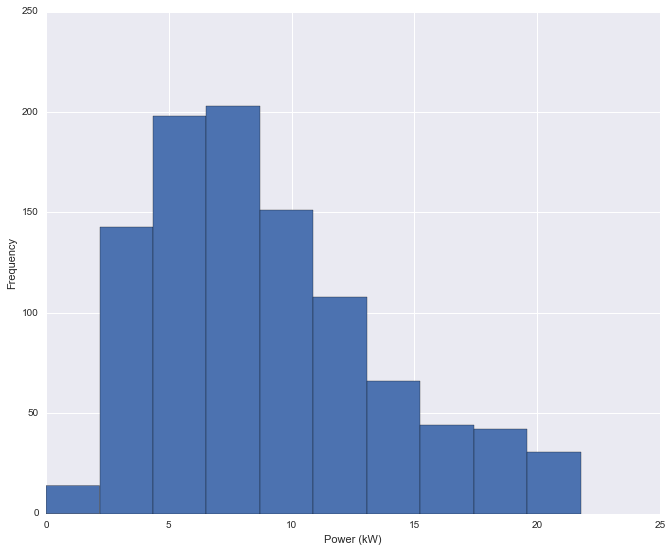

In [129]:
plt.hist(y)
plt.xlabel("Power (kW)")
plt.ylabel("Frequency")

# Using SALib to run a Sensitivity Analysis

SALib is a **free** **open-source** **Python** library

If you use Python, you can install it by running the command

```python
pip install SALib
```

[Documentation](http://salib.readthedocs.org/) is available online and you can also view the code on [Github](http://salib.github.io/SALib/).

The library includes:
* Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087))
* Method of Morris, including groups and optimal trajectories ([Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804), [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805))
* Fourier Amplitude Sensitivity Test (FAST) ([Cukier et al. 1973](http://scitation.aip.org/content/aip/journal/jcp/59/8/10.1063/1.1680571), [Saltelli et al. 1999](http://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485594))
* Delta Moment-Independent Measure ([Borgonovo 2007](http://www.sciencedirect.com/science/article/pii/S0951832006000883), [Plischke et al. 2013](http://www.sciencedirect.com/science/article/pii/S0377221712008995))
* Derivative-based Global Sensitivity Measure (DGSM) ([Sobol and Kucherenko 2009](http://www.sciencedirect.com/science/article/pii/S0378475409000354))
* Fractional Factorial Sensitivity Analysis ([Saltelli et al. 2008](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470059974.html))


### Import the package

In [130]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

### Define a problem file

In the code below, a problem file is used to define the variables we wish to explore

In [131]:
problem = {
    # There are six variables
    'num_vars': 7,
    # These are their names
    'names': ['conn', 'batt', 'dist', 'range', 'dri_eff', 'inv_eff', 'dispatch_time'],
    # These are their plausible ranges over which we'll move the variables
    'bounds': [[2.3, 22], # connection_power (kW)
               [50, 100], # battery size (kWh)
               [0, 80], # distance driven (km)
               [0, 80], # range buffer (km)
               [4,5.5], # driving efficiency (kWh/km)
               [0.87,0.97], # inverter efficienct (%)
               [1, 8]
              ],
    # I don't want to group any of these variables together
    'groups': None
    }

### Generate a Sample

We then generate a sample using the `morris.sample()` procedure from the SALib package.

In [103]:
number_of_trajectories = 100
sample = ms.sample(problem, number_of_trajectories, num_levels=4, grid_jump=2)

We'll run a sensitivity analysis of the power "model" to see which is the most influential parameter

In [104]:
# Run the sample through the monte carlo procedure of the power model
output = monte_carlo_large(sample.T)
# Store the results for plotting of the analysis
Si = ma.analyze(problem, sample, output, print_to_console=True)

Parameter Mu Sigma Mu_Star Mu_Star_Conf
conn 11.137115 8.057324 11.137115 1.512249
batt 2.755864 4.080812 2.755864 0.769296
dist -1.496449 1.936531 1.496449 0.368356
range -1.390740 2.605835 1.390740 0.485812
dri_eff 0.687825 1.898029 0.687825 0.371412
inv_eff 0.377379 0.555029 0.377379 0.102482
dispatch_time -7.451624 7.359381 7.451624 1.438800


Then we plot the results

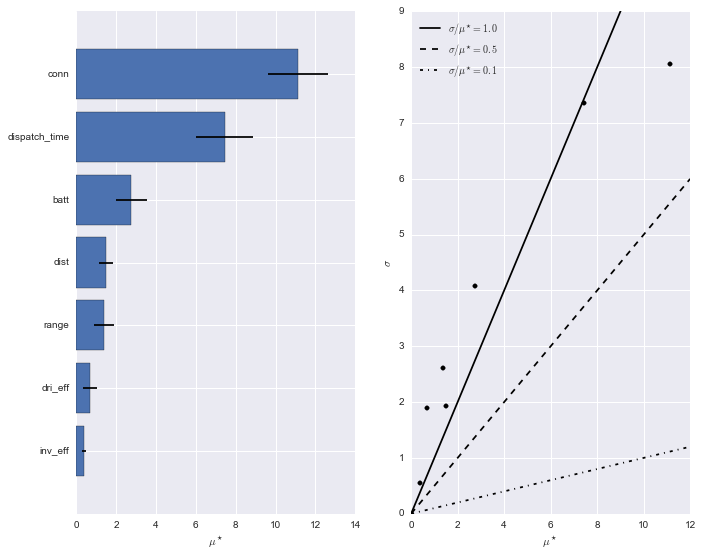

In [105]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si)
mp.covariance_plot(ax2, Si, {})

In [113]:
def battery_lifetime(lifetime_cycles,
                     total_energy_stored,
                     depth_of_discharge
                    ):
    '''
    Compute the lifetime of a battery in energy terms
    
    Arguments:
        lifetime_cycles - 
        total_energy_stored - size of battery (kWh)
        depth_of_discharge - the depth of discharge for which 
                            lifetime_cycles is defined (0 <= DoD <= 1)
    
    Returns:
        battery_lifetime in energy terms - units: kWh
    
    '''
    lifetime = lifetime_cycles * total_energy_stored * depth_of_discharge
    return lifetime

In [116]:
def annualized_capital_cost(cost, discount_rate, lifetime):
    '''
    Arguments:
        cost - in GBP2015
        discount_rate - %
        lifetime - in years
    '''
    ann_cc = cost * (discount_rate / (1-(1+discount_rate)**-lifetime))
    return ann_cc

In [117]:
annualized_capital_cost(1900, 0.1, 10)

309.2162502767719

In [118]:
def compute_profit():

    time_dispatched = 8000 # hours

    battery_size = 27.4 # kWh
    battery_unit_cost = 350 # £/kWh

    connector_power = 14 # kW

    battery_capital_cost = battery_size * battery_unit_cost # 2015£
    lifetime_cycles = 2000
    depth_of_discharge = 0.8

    electricity_price = 0.2 # £/kWh - sell when its expensive
    purchased_energy_cost = 0.05 # £/kWh - buy when it's cheap

    round_trip_efficiency = 0.73 # 73% efficiency grid-battery-grid

    cost_of_v2g_equip = 2000
    discount_rate = 0.1 # 10%
    economic_lifetime = 10

    stored_energy = battery_size * depth_of_discharge # kWh
    distance_driven = 0 # km
    range_buffer = 10 # km

    power_available = max_vehicle_power(connector_power,
                                        stored_energy,
                                        distance_driven,
                                        range_buffer,
                                        8,
                                        )

    energy_dispatched = power_available * time_dispatched

    revenue = electricity_price * energy_dispatched

    cost = cost_of_vehicle_to_grid(battery_capital_cost,
                                   lifetime_cycles,
                                   battery_size,
                                   depth_of_discharge,
                                   purchased_energy_cost,
                                   round_trip_efficiency,
                                   energy_dispatched,
                                   cost_of_v2g_equip,
                                   discount_rate,
                                   economic_lifetime)

    if revenue > cost:
        profit = revenue - cost
    else:
        profit = 0

    return profit, revenue, cost

In [121]:
def cost_of_vehicle_to_grid(battery_capital_cost,
                            lifetime_cycles,
                            total_energy_stored,
                            depth_of_discharge,
                            purchased_energy_cost,
                            round_trip_efficiency,
                            energy_dispatched,
                            cost_of_v2g_equip,
                            discount_rate,
                            economic_lifetime):
    
    battery_life = battery_lifetime(lifetime_cycles,
                                    total_energy_stored,
                                    depth_of_discharge
                                    )
    
    degredation_cost = battery_capital_cost / battery_life
    
    cost_of_energy = (purchased_energy_cost / round_trip_efficiency) \
                        + degredation_cost
    
    annualised_capex = annualized_capital_cost(cost_of_v2g_equip, 
                                               discount_rate, 
                                               economic_lifetime)
    
    cost = (cost_of_energy * energy_dispatched) + annualised_capex
    
    return cost

In [122]:
compute_profit()

(0, 3615.0081987577646, 5517.4225135802189)

# Summary

* Think through your assumptions
* Quantify uncertainty
* Focus on the most influential uncertainties first
* Learn [Python](https://www.python.org)

Similar packages to [SALib]() for other languages/programmes:
* [Matlab Toolbox **SAFE** for GSA](http://www.sciencedirect.com/science/article/pii/S1364815215001188)
* [`sensitivity` package for R](https://cran.r-project.org/web/packages/sensitivity/index.html)
* [Excel](http://crossfitjerseycity.org/wp-content/uploads/2015/01/keep-calm-and-good-luck-graphic1.png)